In [2]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import scipy as sp # type: ignore
from scipy.optimize import curve_fit # type: ignore
import matplotlib.pyplot as plt # type: ignore

# UNITS
ev2au = 1/27.211396132
au2ev = 27.211396132
ang2au = 1/0.529177249
au2ang = 0.529177249
au2fs = 1/41.34137333656
fs2au = 41.34137333656
au2debye = 1/0.39343
debye2au = 0.39343
au2nm = 0.052917720859
nm2au = 1/0.052917720859
au2cm1 = 2.1947463137E5
cm12au = 1/(2.1947463137E5)
au2amu = 1/1822.88848325
amu2au = 1822.88848325
thz2au = 1.0/0.029979/au2cm1

#La suma debe ser una suma de 32 terminos

coeff_matrix = np.zeros((32,4))
coeff_matrix[0,:] = [0,0,1,32849.58]
coeff_matrix[1,:] = [0,1,1,-17553.99]
coeff_matrix[2,:] = [1,0,1,-27625.23]
coeff_matrix[3,:] = [2,0,0,50043.09]
coeff_matrix[4,:] = [4,0,0,336.49]
coeff_matrix[5,:] = [0,1,2,-3360.94]
coeff_matrix[6,:] = [0,3,0,-64.84]
coeff_matrix[7,:] = [1,1,1,18285.40]
coeff_matrix[8,:] = [2,0,1,-7181.44]
coeff_matrix[9,:] = [0,0,4,2553.25]
coeff_matrix[10,:] = [0,2,2,-4905.39]
coeff_matrix[11,:] = [0,4,0,3505.21]
coeff_matrix[12,:] = [1,1,2,-21845.86]
coeff_matrix[13,:] = [1,3,0,-1416.44]
coeff_matrix[14,:] = [2,1,1,5596.86]
coeff_matrix[15,:] = [3,0,1,-142.39]
coeff_matrix[16,:] = [0,0,2,15623.64]
coeff_matrix[17,:] = [0,2,0,72972.84]
coeff_matrix[18,:] = [1,1,0,9857.17]
coeff_matrix[19,:] = [3,0,0,-2376.30]
coeff_matrix[20,:] = [0,2,1,-8550.95]
coeff_matrix[21,:] = [1,0,2,-4597.25]
coeff_matrix[22,:] = [1,2,0,-657.28]
coeff_matrix[23,:] = [2,1,0,1985.36]
coeff_matrix[24,:] = [0,1,3,-5546.12]
coeff_matrix[25,:] = [0,3,1,-11098.50]
coeff_matrix[26,:] = [1,0,3,-9178.03]
coeff_matrix[27,:] = [1,2,1,948.74]
coeff_matrix[28,:] = [2,0,2,-983.04]
coeff_matrix[29,:] = [2,2,0,-584.78]
coeff_matrix[30,:] = [3,1,0,1694.77]
coeff_matrix[31,:] = [0,0,3,4971.79]

def V(R1,R2,theta):
    R1e = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
    R2e = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
    alpha_1 = 1.95/ang2au #Amstrong^-1
    alpha_2 = 2.34/ang2au #Amstrong^-1
    theta_e = np.pi #Degrees

    aR1 = -alpha_1*(R1-R1e)
    aR2 = -alpha_2*(R2-R2e)

    y_1 = 1.0 - np.exp(aR1)
    y_2 = 1.0 - np.exp(aR2)
    y_3 = np.cos(theta) - np.cos(theta_e)

    suma = 0.0
    for i in range(32):
        suma = suma + (coeff_matrix[i,3]*cm12au)*(y_1**int(coeff_matrix[i,0]))*(y_2**int(coeff_matrix[i,1]))*(y_3**(coeff_matrix[i,2]))
    return(suma)

In [3]:
q1 = np.concatenate((np.linspace(1.45,5.0,20),np.linspace(5.0, 8, 10))) #Azul
q2 = np.concatenate((np.linspace(1.6,5.0,20),np.linspace(5.0, 8, 10))) #Naranja
R1_eq = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
R2_eq = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
theta_eq = np.pi

# Generacion del archivo de datos
data_set = np.zeros((len(q1)**2,3)) #Dim(729,3)
l = 0 #Inicializa en 0
for i in range(len(q1)): #R1
    for j in range(len(q2)): #R2
        data_set[l,:] = q1[i],q2[j],V(q1[i],q2[j],np.pi) #Obtenemos valores para R1, R2 y V(R1,R2)
        l = l + 1

df = pd.DataFrame(data_set)
df.columns = ['R1','R2','V'] #Renombramos las columnas

inputsmodel = df.drop('V', axis=1)
target = df.iloc[:,-1]

In [4]:
from scipy.optimize import curve_fit # type: ignore

def morsepotential(q, D, alpha, E0, R_eq):
    return D*(1.0 - np.exp(-alpha*(q-R_eq)))**2 + E0

xdata = np.concatenate((np.linspace(1.6,5.0,20),np.linspace(5.0, 8, 10))) #q2, CHECK
morse_parameters = np.zeros((len(q1),5))

for i in range(len(q1)): #En este range cambio la forma de graficar
    ydata = V(q1[i],xdata,theta_eq) #Potencial segun xdata
    popt, pcov = curve_fit(morsepotential, xdata, ydata, p0=[3.49440974e-01,  1.22952512e+00, -1.73828756e-03    ,  2.18903764e+00]) #Se hace el fitting considerando un p0 inicial para el resto
    
    morse_parameters[i,0] = q1[i]
    morse_parameters[i,1:] = popt
    
    dfMorse = pd.DataFrame(morse_parameters[:]) #Creo el dataset de los valores
    dfMorse.columns = ['q','D','alpha','E','Req']
    
print("Las dimensiones de los parametros de los morses son: ",morse_parameters.shape)
dfMorse

dfaxu = pd.DataFrame(dfMorse.loc[dfMorse.index.repeat(30)].reset_index(drop=True))
dfFinal = pd.concat([df,dfaxu],axis=1)

fit_v = []

for i, row, in dfFinal.iterrows():
    R2 = row['R2']
    D = row['D']
    alpha = row['alpha']
    E = row['E']
    Req = row['Req']
    
    potential = morsepotential(R2,D,alpha,E,Req)
    fit_v.append(potential)
    
dfFinal['VFitting'] = fit_v

Las dimensiones de los parametros de los morses son:  (30, 5)


In [5]:
v00 = np.load('TrainRES_0.001_EPs2000_Lambda0.0.npy')
v02 = np.load('TrainRES_0.001_EPs2000_Lambda0.2.npy')
v04 = np.load('TrainRES_0.001_EPs2000_Lambda0.4.npy')
v06 = np.load('TrainRES_0.001_EPs2000_Lambda0.6.npy')
v08 = np.load('TrainRES_0.001_EPs2000_Lambda0.8.npy') 
v10 = np.load('TrainRES_0.001_EPs2000_Lambda1.0.npy')
y_pred = [v00, v02, v04, v06, v08, v10]

v2_00 = np.load('2TrainRES_0.001_EPs2000_Lambda0.0.npy')
v2_02 = np.load('2TrainRES_0.001_EPs2000_Lambda0.2.npy')
v2_04 = np.load('2TrainRES_0.001_EPs2000_Lambda0.4.npy')
v2_06 = np.load('2TrainRES_0.001_EPs2000_Lambda0.6.npy')
v2_08 = np.load('2TrainRES_0.001_EPs2000_Lambda0.8.npy') 
v2_10 = np.load('2TrainRES_0.001_EPs2000_Lambda1.0.npy')
y_pred2 = [v2_00, v2_02, v2_04, v2_06, v2_08, v2_10]

Text(0.5, 1.0, '$\\lambda=1.0$')

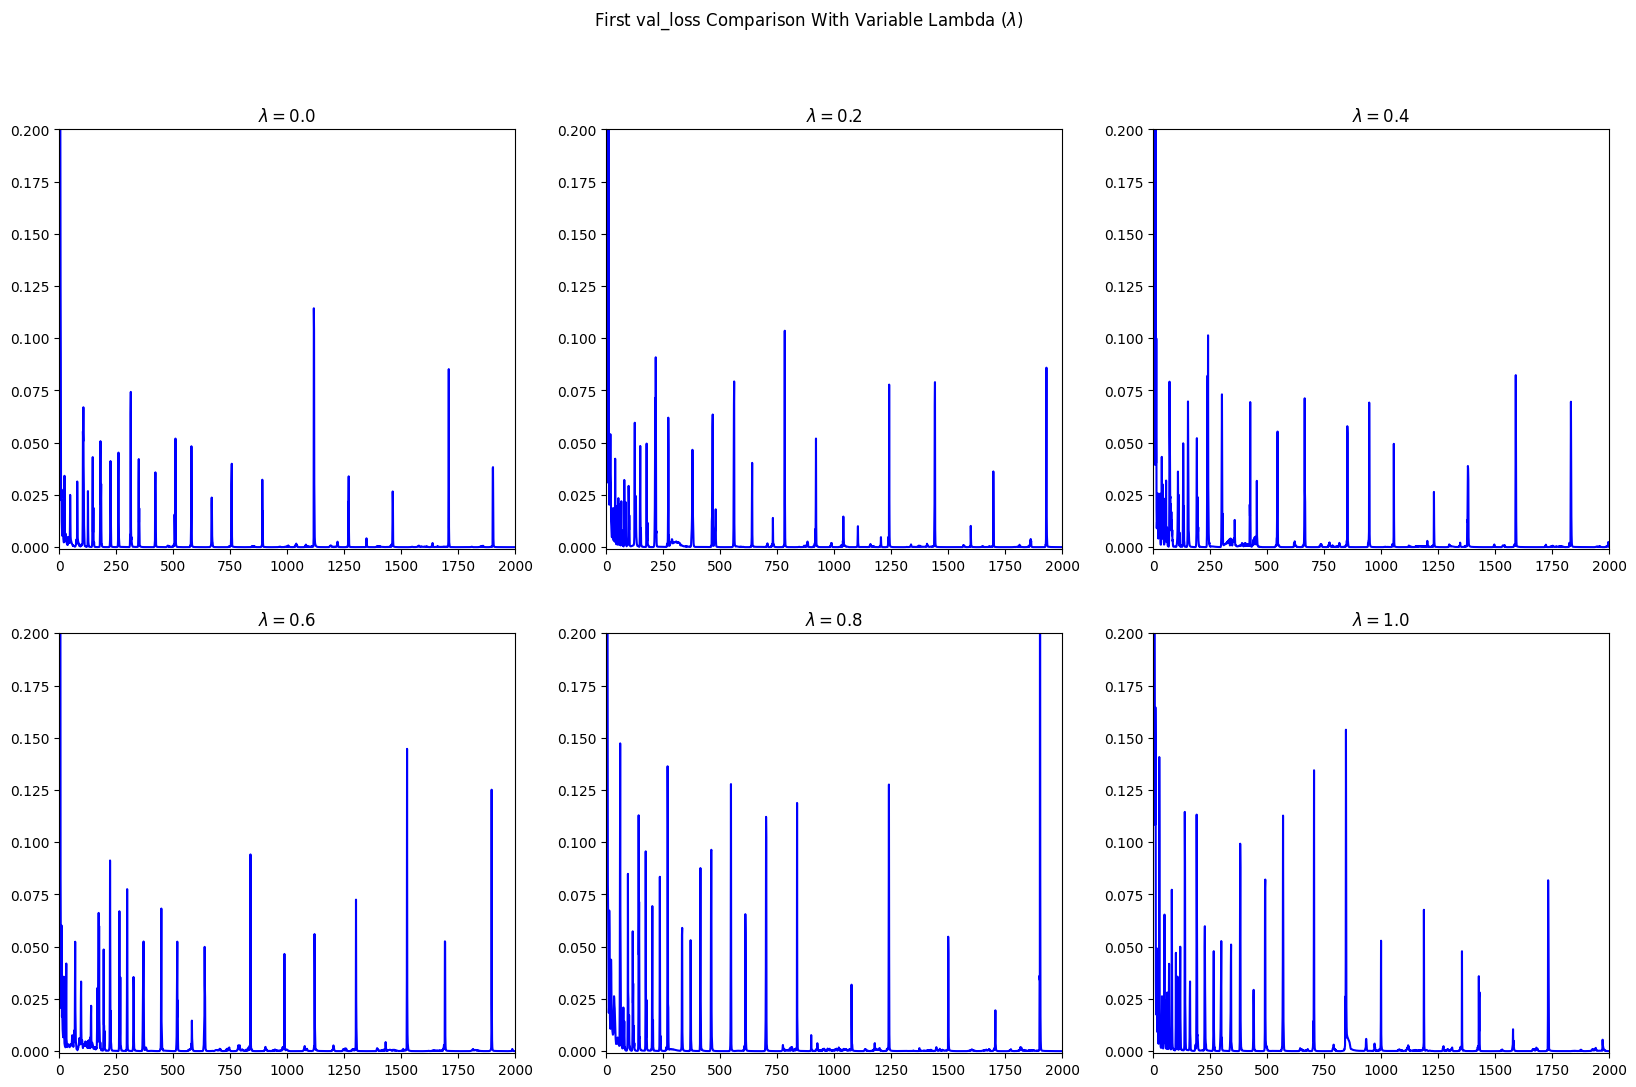

In [6]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20, 12))
fig.suptitle('First val_loss Comparison With Variable Lambda ($\lambda$)')
ax1.plot(v00[1,:], color='blue')
ax1.axis([0, 2000, -0.001, 0.2])
ax1.set_title('$\lambda=0.0$')
ax2.plot(v02[1,:], color='blue')
ax2.axis([0, 2000, -0.001, 0.2])
ax2.set_title('$\lambda=0.2$')
ax3.plot(v04[1,:], color='blue')
ax3.axis([0, 2000, -0.001, 0.2])
ax3.set_title('$\lambda=0.4$')
ax4.plot(v06[1,:], color='blue')
ax4.axis([0, 2000, -0.001, 0.2])
ax4.set_title('$\lambda=0.6$')
ax5.plot(v08[1,:], color='blue')
ax5.axis([0, 2000, -0.001, 0.2])
ax5.set_title('$\lambda=0.8$')
ax6.plot(v10[1,:], color='blue')
ax6.axis([0, 2000, -0.001, 0.2])
ax6.set_title('$\lambda=1.0$')

Text(0.5, 1.0, '$\\lambda=1.0$')

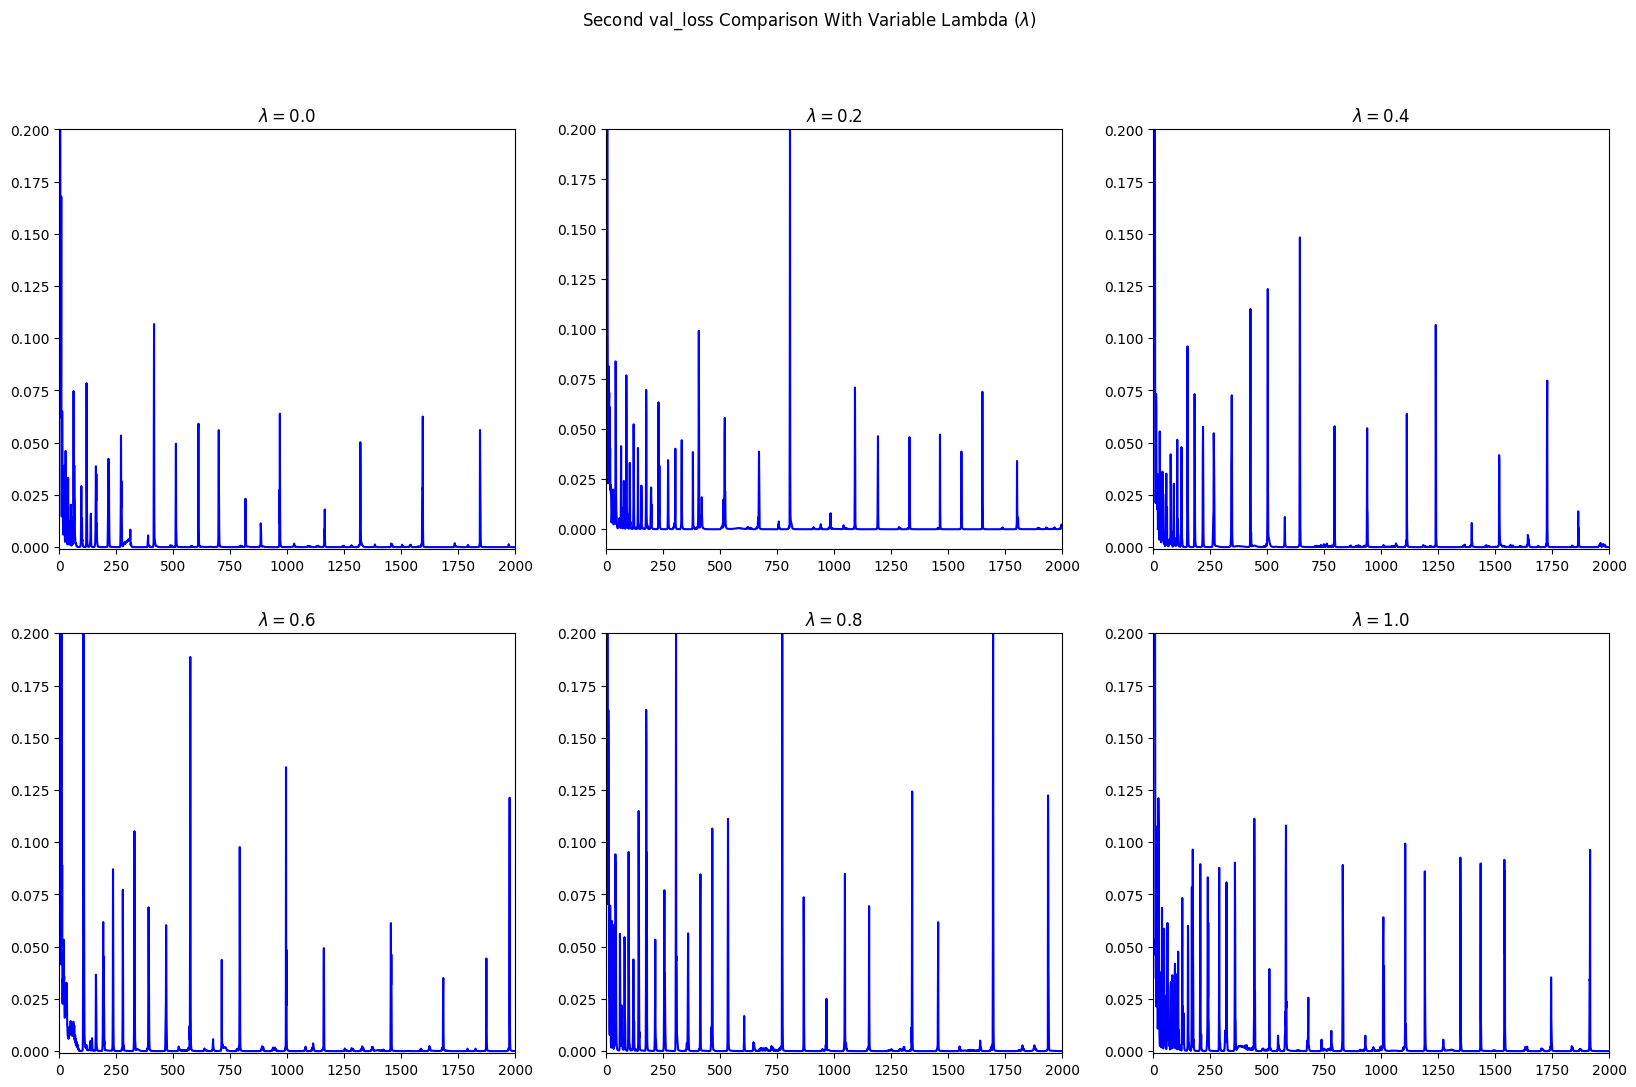

In [7]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20, 12))
fig.suptitle('Second val_loss Comparison With Variable Lambda ($\lambda$)')
ax1.plot(v2_00[1,:], color='blue')
ax1.axis([0, 2000, -0.001, 0.2])
ax1.set_title('$\lambda=0.0$')
ax2.plot(v2_02[1,:], color='blue')
ax2.axis([0, 2000, -0.01, 0.2])
ax2.set_title('$\lambda=0.2$')
ax3.plot(v2_04[1,:], color='blue')
ax3.axis([0, 2000, -0.001, 0.2])
ax3.set_title('$\lambda=0.4$')
ax4.plot(v2_06[1,:], color='blue')
ax4.axis([0, 2000, -0.001, 0.2])
ax4.set_title('$\lambda=0.6$')
ax5.plot(v2_08[1,:], color='blue')
ax5.axis([0, 2000, -0.001, 0.2])
ax5.set_title('$\lambda=0.8$')
ax6.plot(v2_10[1,:], color='blue')
ax6.axis([0, 2000, -0.001, 0.2])
ax6.set_title('$\lambda=1.0$')

In [8]:
c00 = np.load('TrainPREDS_0.001_EPs2000_Lambda0.0.npy')
c02 = np.load('TrainPREDS_0.001_EPs2000_Lambda0.2.npy')
c04 = np.load('TrainPREDS_0.001_EPs2000_Lambda0.4.npy')
c06 = np.load('TrainPREDS_0.001_EPs2000_Lambda0.6.npy')
c08 = np.load('TrainPREDS_0.001_EPs2000_Lambda0.8.npy') 
c10 = np.load('TrainPREDS_0.001_EPs2000_Lambda1.0.npy')
y_contours = [c00, c02, c04, c06, c08, c10]

(2.0, 8.0, 1.8, 7.5)

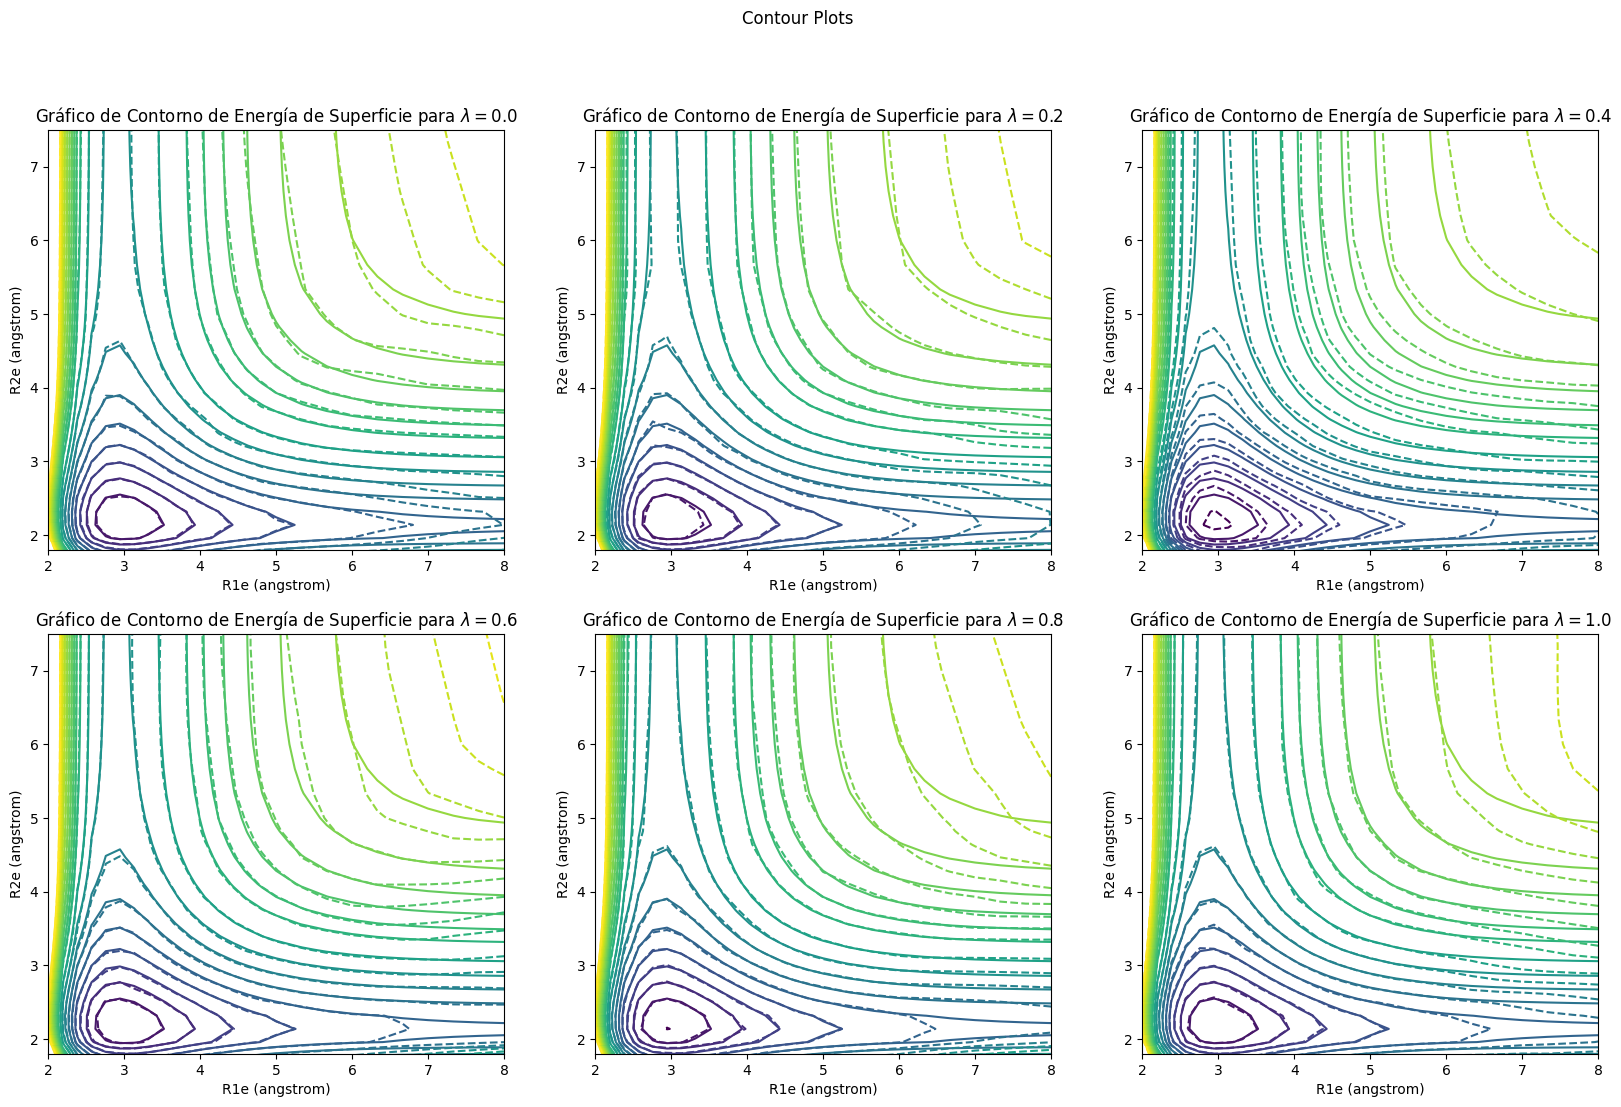

In [9]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20, 12))
fig.suptitle('Contour Plots')


#Lectura de los datos para contornos
R2e, R1e = np.meshgrid(q2, q1)
energia_superficie = np.vectorize(V)(R1e, R2e, np.pi) # type: ignore
energia_superficie0 =  c00[1,:].reshape(len(q2),len(q2))
energia_superficie2 =  c02[1,:].reshape(len(q2),len(q2))
energia_superficie4 =  c04[1,:].reshape(len(q2),len(q2))
energia_superficie6 =  c06[1,:].reshape(len(q2),len(q2))
energia_superficie8 =  c08[1,:].reshape(len(q2),len(q2))
energia_superficie1 =  c10[1,:].reshape(len(q2),len(q2))

Ncontours = 20
level_min = 0.0
level_max = 0.7
levels0 = np.concatenate((np.linspace(level_min,0.4,Ncontours-10), np.linspace(0.45,level_max,10)))

#Plot de los contornos predichos vs real
ctreal = ax1.contour(R1e, R2e, energia_superficie, levels0, vmin=level_min, vmax=level_max)
ctpred = ax1.contour(R1e, R2e, energia_superficie0, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax2.contour(R1e, R2e, energia_superficie, levels0, vmin=level_min, vmax=level_max)
ctpred = ax2.contour(R1e, R2e, energia_superficie2, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax3.contour(R1e, R2e, energia_superficie, levels0, vmin=level_min, vmax=level_max)
ctpred = ax3.contour(R1e, R2e, energia_superficie4, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax4.contour(R1e, R2e, energia_superficie, levels0, vmin=level_min, vmax=level_max)
ctpred = ax4.contour(R1e, R2e, energia_superficie6, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax5.contour(R1e, R2e, energia_superficie, levels0, vmin=level_min, vmax=level_max)
ctpred = ax5.contour(R1e, R2e, energia_superficie8, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')
ctreal = ax6.contour(R1e, R2e, energia_superficie, levels0, vmin=level_min, vmax=level_max)
ctpred = ax6.contour(R1e, R2e, energia_superficie1, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')

# Info de plots
ax1.set_xlabel('R1e (angstrom)')
ax1.set_ylabel('R2e (angstrom)')
ax1.set_title('Gráfico de Contorno de Energía de Superficie para $\lambda=0.0$')
ax1.axis([2.0,8.0,1.8,7.5])
ax2.set_xlabel('R1e (angstrom)')
ax2.set_ylabel('R2e (angstrom)')
ax2.set_title('Gráfico de Contorno de Energía de Superficie para $\lambda=0.2$')
ax2.axis([2.0,8.0,1.8,7.5])
ax3.set_xlabel('R1e (angstrom)')
ax3.set_ylabel('R2e (angstrom)')
ax3.set_title('Gráfico de Contorno de Energía de Superficie para $\lambda=0.4$')
ax3.axis([2.0,8.0,1.8,7.5])
ax4.set_xlabel('R1e (angstrom)')
ax4.set_ylabel('R2e (angstrom)')
ax4.set_title('Gráfico de Contorno de Energía de Superficie para $\lambda=0.6$')
ax4.axis([2.0,8.0,1.8,7.5])
ax5.set_xlabel('R1e (angstrom)')
ax5.set_ylabel('R2e (angstrom)')
ax5.set_title('Gráfico de Contorno de Energía de Superficie para $\lambda=0.8$')
ax5.axis([2.0,8.0,1.8,7.5])
ax6.set_xlabel('R1e (angstrom)')
ax6.set_ylabel('R2e (angstrom)')
ax6.set_title('Gráfico de Contorno de Energía de Superficie para $\lambda=1.0$')
ax6.axis([2.0,8.0,1.8,7.5])

(-0.1, 5.0, -0.1, 5.0)

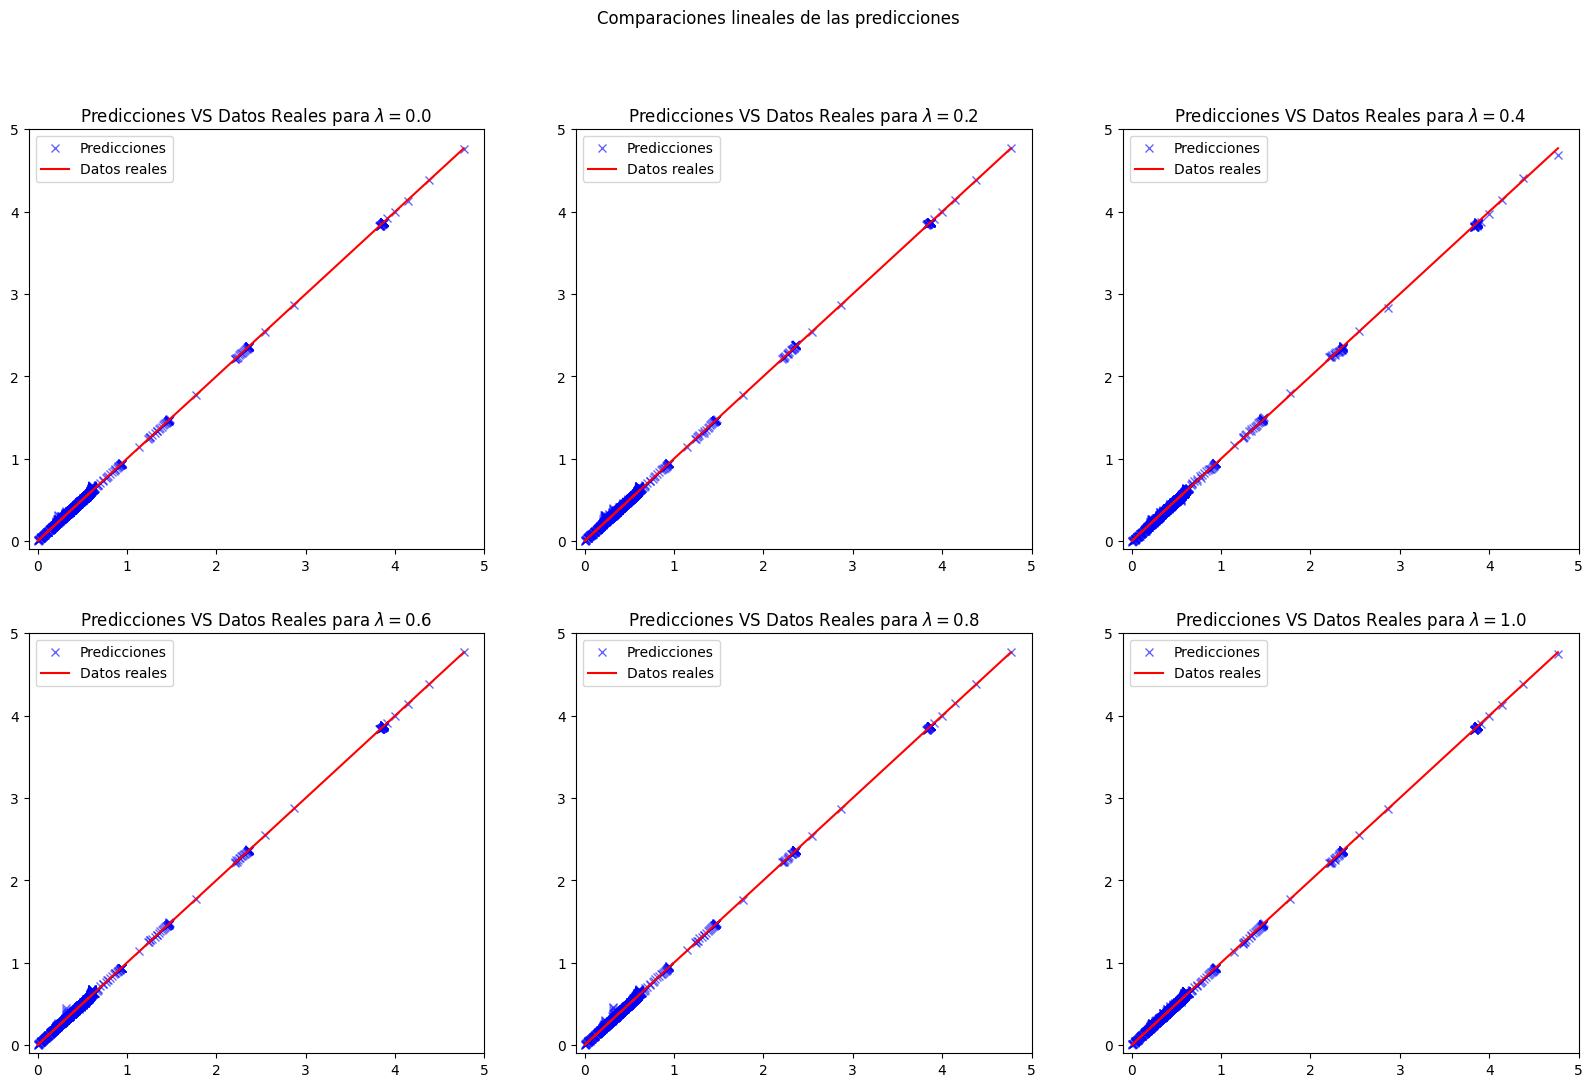

In [10]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20, 12))
fig.suptitle('Comparaciones lineales de las predicciones')

ax1.plot(c00[0,:], c00[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax1.plot(c00[0,:], c00[0,:], color='red', label='Datos reales')
ax1.legend()
ax1.set_title("Predicciones VS Datos Reales para $\lambda=0.0$")
ax1.axis([-0.1,5,0.-0.1,5])
ax2.plot(c02[0,:], c02[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax2.plot(c02[0,:], c02[0,:], color='red', label='Datos reales')
ax2.legend()
ax2.set_title("Predicciones VS Datos Reales para $\lambda=0.2$")
ax2.axis([-0.1,5,-0.1,5])
ax3.plot(c04[0,:], c04[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax3.plot(c04[0,:], c04[0,:], color='red', label='Datos reales')
ax3.legend()
ax3.set_title("Predicciones VS Datos Reales para $\lambda=0.4$")
ax3.axis([-0.1,5,-0.1,5])
ax4.plot(c06[0,:], c06[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax4.plot(c06[0,:], c06[0,:], color='red', label='Datos reales')
ax4.legend()
ax4.set_title("Predicciones VS Datos Reales para $\lambda=0.6$")
ax4.axis([-0.1,5,-0.1,5])
ax5.plot(c08[0,:], c08[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax5.plot(c08[0,:], c08[0,:], color='red', label='Datos reales')
ax5.legend()
ax5.set_title("Predicciones VS Datos Reales para $\lambda=0.8$")
ax5.axis([-0.1,5,-0.1,5])
ax6.plot(c10[0,:], c10[1,:],'x', label="Predicciones", color='blue', alpha=0.6)
ax6.plot(c10[0,:], c10[0,:], color='red', label='Datos reales')
ax6.legend()
ax6.set_title("Predicciones VS Datos Reales para $\lambda=1.0$")
ax6.axis([-0.1,5,-0.1,5])

## Raissi dice que naturalmente las PINN deberian funcionar bien con pocos puntos, por lo que probaremos el mismo modelo de NN, con $\lambda=0.0$, disminuyendo puntos totales para descubrir el error del MSE al disminuir datos

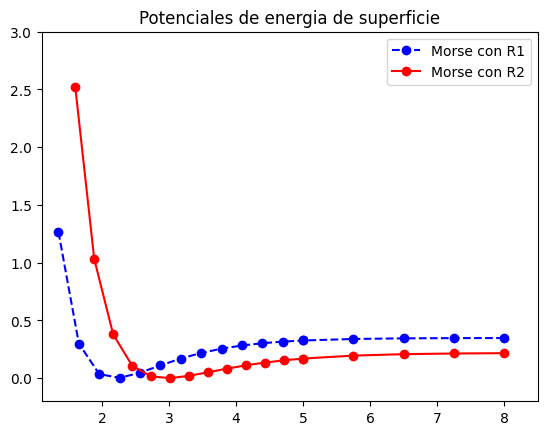

In [24]:
#Para 28 puntos
q1 = np.concatenate((np.linspace(1.35,5.0,19),np.linspace(5.0, 8, 9))) #Azul
q2 = np.concatenate((np.linspace(1.6,5.0,19),np.linspace(5.0, 8, 9))) #Naranja
#Para 26 puntos
q1 = np.concatenate((np.linspace(1.35,5.0,18),np.linspace(5.0, 8, 8))) #Azul
q2 = np.concatenate((np.linspace(1.6,5.0,18),np.linspace(5.0, 8, 8))) #Naranja
#Para 24 puntos
q1 = np.concatenate((np.linspace(1.35,5.0,17),np.linspace(5.0, 8, 7))) #Azul
q2 = np.concatenate((np.linspace(1.6,5.0,17),np.linspace(5.0, 8, 7))) #Naranja
#Para 22 puntos
q1 = np.concatenate((np.linspace(1.35,5.0,16),np.linspace(5.0, 8, 6))) #Azul
q2 = np.concatenate((np.linspace(1.6,5.0,16),np.linspace(5.0, 8, 6))) #Naranja
#Para 20 puntos
q1 = np.concatenate((np.linspace(1.35,5.0,15),np.linspace(5.0, 8, 5))) #Azul
q2 = np.concatenate((np.linspace(1.6,5.0,15),np.linspace(5.0, 8, 5))) #Naranja
#Para 18 puntos
q1 = np.concatenate((np.linspace(1.35,5.0,13),np.linspace(5.0, 8, 5))) #Azul
q2 = np.concatenate((np.linspace(1.6,5.0,13),np.linspace(5.0, 8, 5))) #Naranja


R1_eq = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
R2_eq = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
theta_eq = np.pi

plt.plot(q1, V(R1_eq,q1,theta_eq), "o--", label="Morse con R1", color="blue")
plt.plot(q2, V(q2,R2_eq,theta_eq),"o-",label="Morse con R2", color="red")
plt.legend()
plt.axis([1.1,8.5,-0.2,3])
plt.title("Potenciales de energia de superficie")
plt.show()